In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


# Load an color image in grayscale
img = cv2.imread('chess1.jpg',0)

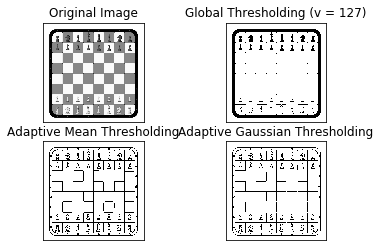

In [12]:

img = cv2.imread('chess1.jpg',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


In [16]:
g=cv2.imwrite("Thres.jpg",th2)

In [7]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img1 = cv.imread('chess.jpg',0)
img = cv2.GaussianBlur(img1,(5,5),0)

edges = cv.Canny(img,400,400)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()
k1=cv2.imwrite("ed.jpg",edges)

<Figure size 640x480 with 2 Axes>

In [8]:
import cv2
import numpy as np

img = cv2.imread('ed.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

cv2.imwrite('houghlines5.jpg',img)

True

In [9]:
img = cv2.imread('ed.jpg')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,150,200,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)
for line in lines:

    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imwrite('houghlines3.jpg',img)

True

In [211]:
import numpy as np
import scipy.spatial as spatial
import scipy.cluster as clstr
from time import time
from collections import defaultdict
from functools import partial
from sklearn.utils import shuffle
import os, glob, skimage, cv2, shutil

SQUARE_SIDE_LENGTH = 227
categories = ['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']


In [212]:
def auto_canny(image, sigma=0.33):
    """
    Canny edge detection with automatic thresholds.
    """
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

def hor_vert_lines(lines):
    """
    A line is given by rho and theta. Given a list of lines, returns a list of
    horizontal lines (theta=90 deg) and a list of vertical lines (theta=0 deg).
    """
    h = []
    v = []
    for distance, angle in lines:
        if angle < np.pi / 4 or angle > np.pi - np.pi / 4:
            v.append([distance, angle])
        else:
            h.append([distance, angle])
    return h, v

def intersections(h, v):
    """
    Given lists of horizontal and vertical lines in (rho, theta) form, returns list
    of (x, y) intersection points.
    """
    points = []
    for d1, a1 in h:
        for d2, a2 in v:
            A = np.array([[np.cos(a1), np.sin(a1)], [np.cos(a2), np.sin(a2)]])
            b = np.array([d1, d2])
            point = np.linalg.solve(A, b)
            points.append(point)
    return np.array(points)

def cluster(points, max_dist=50):
    """
    Given a list of points, returns a list of cluster centers.
    """
    Y = spatial.distance.pdist(points)
    Z = clstr.hierarchy.single(Y)
    T = clstr.hierarchy.fcluster(Z, max_dist, 'distance')
    clusters = defaultdict(list)
    for i in range(len(T)):
        clusters[T[i]].append(points[i])
    clusters = clusters.values()
    clusters = list(map(lambda arr: (np.mean(np.array(arr)[:,0]), np.mean(np.array(arr)[:,1])), clusters))
    return clusters

def closest_point(points, loc):
    """
    Returns the list of points, sorted by distance from loc.
    """
    dists = np.array(list(map(partial(spatial.distance.euclidean, loc), points)))
    return points[dists.argmin()]

def find_corners(points, img_dim):
    """
    Given a list of points, returns a list containing the four corner points.
    """
    center_point = closest_point(points, (img_dim[0] / 2, img_dim[1] / 2))
    points.remove(center_point)
    center_adjacent_point = closest_point(points, center_point)
    points.append(center_point)
    grid_dist = spatial.distance.euclidean(np.array(center_point), np.array(center_adjacent_point))
    
    img_corners = [(0, 0), (0, img_dim[1]), img_dim, (img_dim[0], 0)]
    board_corners = []
    tolerance = 0.25 # bigger = more tolerance
    for img_corner in img_corners:
        while True:
            cand_board_corner = closest_point(points, img_corner)
            points.remove(cand_board_corner)
            cand_board_corner_adjacent = closest_point(points, cand_board_corner)
            corner_grid_dist = spatial.distance.euclidean(np.array(cand_board_corner), np.array(cand_board_corner_adjacent))
            if corner_grid_dist > (1 - tolerance) * grid_dist and corner_grid_dist < (1 + tolerance) * grid_dist:
                points.append(cand_board_corner)
                board_corners.append(cand_board_corner)
                break
    return board_corners

def four_point_transform(img, points, square_length=SQUARE_SIDE_LENGTH):
    board_length = square_length * 8
    pts1 = np.float32(points)
    pts2 = np.float32([[0, 0], [0, board_length], [board_length, board_length], [board_length, 0]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(img, M, (board_length, board_length))

In [213]:
def find_board(fname):
    """
    Given a filename, returns the board image.
    """
    start = time()
    img = cv2.imread(fname)
    assert img is not None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.blur(gray, (3, 3)) # TODO auto adjust the size of the blur
    
    # Canny edge detection
    edges = auto_canny(gray)
    assert np.count_nonzero(edges) / float(gray.shape[0] * gray.shape[1]) < 0.035

    # Hough line detection
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    lines = np.reshape(lines, (-1, 2))
    
    # Compute intersection points
    h, v = hor_vert_lines(lines)
    assert len(h) >= 9
    assert len(v) >= 9
    points = intersections(h, v) 
        
    if False:
        for rho, theta in lines:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 4000*(-b))
            y1 = int(y0 + 4000*(a))
            x2 = int(x0 - 4000*(-b))
            y2 = int(y0 - 4000*(a))
            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
        cv2.imwrite('lines.jpg', img)
    
    # Cluster intersection points
    points = cluster(points)
    
    # Find corners
    img_shape = np.shape(img)
    points = find_corners(points, (img_shape[1], img_shape[0]))
    
    if False:
        for point in points:
            cv2.circle(img, tuple(point), 25, (0,0,255), -1)
        cv2.imwrite('points.jpg', img)
    
    # Perspective transform
    new_img = four_point_transform(img, points)

    return new_img

def split_board(img):
    """
    Given a board image, returns an array of 64 smaller images.
    """
    arr = []
    sq_len = img.shape[0] / 8
    for i in range(8):
        for j in range(8):
            arr.append(img[i * sq_len : (i + 1) * sq_len, j * sq_len : (j + 1) * sq_len])
    return arr

cv2.imwrite('crop.jpg', find_board('frame1.jpg'))

True

In [199]:
#whitepawn
import cv2
import numpy as np
img = cv2.imread('chess.png')
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("wpawn.png",0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)
cv2.imwrite('detectedwpawn.png',img_rgb)

True

In [224]:
#Blackpawn
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("bpawn.png",0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_rgb,'Black pawn',(w_pawn_white,h_pawn_white), font, 1,(0,255,255),2,cv2.LINE_AA)
cv2.imwrite('detectedbpawn.png',img_rgb)


True

In [201]:
#whiteknight
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("wknight.png",0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)    
cv2.imwrite('detectedwknight.png',img_rgb)


True

In [202]:
#whitebishop

img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("wbishop.png",0)
pawn_white_template=cv2.GaussianBlur(pawn_white_template,(3,3),0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)

cv2.imwrite('detectedwbishop.png',img_rgb)

True

In [203]:
#WhiteRook
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("wrook.png",0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)
cv2.imwrite('detectedwrook.png',img_rgb)

True

In [204]:
#WhiteQueen
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("wqueen.png",0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)
cv2.imwrite('detectedwqueen.png',img_rgb)

True

In [205]:
#WhiteKing
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("wking.png",0)    
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)
cv2.imwrite('detectedwking.png',img_rgb)

True

In [206]:
#Blackking
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("bking.png",0)    
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)
cv2.imwrite('detectedbking.png',img_rgb)

True

In [207]:
#BlackQueen
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("bqueen.png",0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)
cv2.imwrite('detectedbqueen.png',img_rgb)

True

In [208]:
#BlackRook
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("brook.png",0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)
cv2.imwrite('detectedbrook.png',img_rgb)

True

In [209]:
#blackbishop
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("bbishop.png",0)
pawn_white_template=cv2.GaussianBlur(pawn_white_template,(3,3),0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)

cv2.imwrite('detectedbbishop.png',img_rgb)

True

In [210]:
#blackknight
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
pawn_white_template = cv2.imread("bknight.png",0)
pawn_white_template=cv2.GaussianBlur(pawn_white_template,(3,3),0)
w_pawn_white, h_pawn_white = pawn_white_template.shape[::-1]
res_pawn_white = cv2.matchTemplate(img_gray,pawn_white_template,cv2.TM_CCOEFF_NORMED)
threshhold = 0.7
loc = np.where(res_pawn_white >= threshhold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb,pt,(pt[0]+w_pawn_white, pt[1]+h_pawn_white),(0,255,255),1)

cv2.imwrite('detectedbknight.png',img_rgb)

True

In [197]:

#similarity of 2 images
# import the necessary packages
import cv2 as cv2

from skimage import measure

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [22]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
 
def compare_images(imageA, imageB, title):
	# compute the mean squared error and structural similarity
	# index for the images
	m = mse(imageA, imageB)
#s = ssim(imageA, imageB)
	s = measure.compare_ssim(imageA, imageB)
	# setup the figure
	fig = plt.figure(title)
	plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
 
	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(imageA, cmap = plt.cm.gray)
	plt.axis("off")
 
	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(imageB, cmap = plt.cm.gray)
	plt.axis("off")
 
	# show the images
	plt.show()


In [33]:
orig = cv2.imread("ss1.png")
cont = cv2.imread("ss2.png")
shop = cv2.imread("ch.jpg")

from PIL import Image

from resizeimage import resizeimage
import numpy as np

width = 455
height = 460
dim = (width, height)
 
# resize image
original = cv2.resize(orig, dim, interpolation = cv2.INTER_AREA)
contrast = cv2.resize(cont, dim, interpolation = cv2.INTER_AREA)
shopped = cv2.resize(shop, dim, interpolation = cv2.INTER_AREA)
 

# convert the images to grayscale
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
contrast = cv2.cvtColor(contrast, cv2.COLOR_BGR2GRAY)
shopped = cv2.cvtColor(shopped, cv2.COLOR_BGR2GRAY)

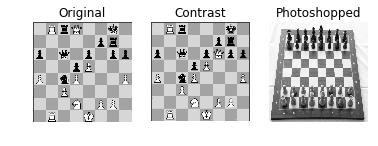

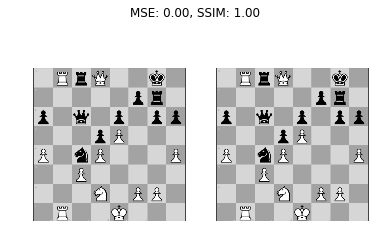

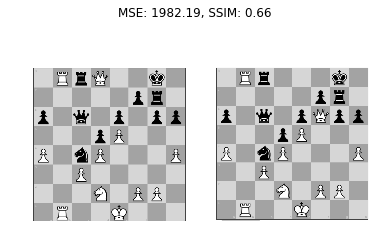

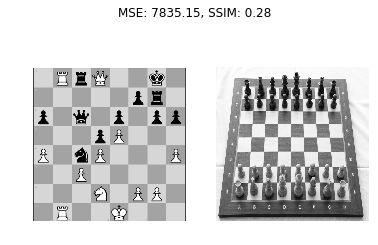

In [34]:
# initialize the figure
fig = plt.figure("Images")
images = ("Original", original), ("Contrast", contrast), ("Photoshopped", shopped)
 
# loop over the images
for (i, (name, image)) in enumerate(images):
	# show the image
	ax = fig.add_subplot(1,3, i + 1)
	ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")
plt.show()
 
# compare the images
compare_images(original, original, "Original vs. Original")
compare_images(original, contrast, "Original vs. Contrast")
compare_images(original, shopped, "Original vs. Photoshopped")


SSIM: 0.6574644983475801


/home/tcs/.local/lib/python3.5/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


In [65]:
#extract frames
import cv2 
import os
def FrameCapture(path): 
      
    vidObj = cv2.VideoCapture(path) 
  
    count = 0
  
    success = 1
  
    while success: 

        success, image = vidObj.read() 
        path = 'home/tcs/ChessCV/frames'

        cv2.imwrite("frame%d.jpg" % count, image) 

        count += 1
  
# Driver Code 
if __name__ == '__main__': 
        FrameCapture("chess.mp4") 

In [1]:
#detect squares

NameError: name 'cv2' is not defined

In [30]:
import cv2
import numpy as np
im=cv2.imread("chess.png")
img = cv2.imread('chess.png')
img = cv2.GaussianBlur(img,(3,3),0)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
mask = np.zeros((gray.shape),np.uint8)
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))

close = cv2.morphologyEx(gray,cv2.MORPH_CLOSE,kernel1)
div = np.float32(gray)/(close)
res = np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX))
res2 = cv2.cvtColor(res,cv2.COLOR_GRAY2BGR)
thresh = cv2.adaptiveThreshold(res,255,0,1,19,2)
cv2.imwrite("th.png",thresh)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


True

In [31]:

_,contour,_= cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

max_area = 0
best_cnt = None
for cnt in contour:
    area = cv2.contourArea(cnt)
    if area > 1000:
        if area > max_area:
            max_area = area
            best_cnt = cnt

cv2.drawContours(mask,[best_cnt],0,255,-1)
cv2.drawContours(mask,[best_cnt],0,0,2)

res = cv2.bitwise_and(res,mask)


In [32]:
kernelx = cv2.getStructuringElement(cv2.MORPH_RECT,(2,8))

dx = cv2.Sobel(gray,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
close = cv2.morphologyEx(close,cv2.MORPH_ERODE,kernelx,iterations = 1)

_,contour,_= cv2.findContours(close,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    x,y,w,h = cv2.boundingRect(cnt)
    if h/w > 20:
        cv2.drawContours(close,[cnt],0,255,-1)
    else:
        cv2.drawContours(close,[cnt],0,0,-1)
close = cv2.morphologyEx(close,cv2.MORPH_CLOSE,None,iterations = 2)
kernel = np.ones((20,1), np.uint8)  # note this is a horizontal kernel
d_im = cv2.dilate(close, kernel, iterations=2)
e_im = cv2.erode(d_im, kernel, iterations=1) 


closey = e_im.copy()


cv2.imwrite("closev.png",closey)

True

In [33]:
kernely = cv2.getStructuringElement(cv2.MORPH_RECT,(8,2))

dy = cv2.Sobel(gray,cv2.CV_16S,0,1)
dy = cv2.convertScaleAbs(dy)
cv2.normalize(dy,dy,0,255,cv2.NORM_MINMAX)
ret,close = cv2.threshold(dy,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
close = cv2.morphologyEx(close,cv2.MORPH_ERODE,kernely,iterations = 1)

_,contour,_= cv2.findContours(close,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    x,y,w,h = cv2.boundingRect(cnt)
    if w/h > 20:
        cv2.drawContours(close,[cnt],0,255,-1)
    else:
        cv2.drawContours(close,[cnt],0,0,-1)
close = cv2.morphologyEx(close,cv2.MORPH_CLOSE,None,iterations = 3)
kernel = np.ones((1,20), np.uint8)  # note this is a horizontal kernel
d_im = cv2.dilate(close, kernel, iterations=3)
e_im = cv2.erode(d_im, kernel, iterations=1) 


closey1 = e_im.copy()


cv2.imwrite("closeh1.png",closey1)

True

In [34]:
res1 = cv2.bitwise_and(closey,closey1)

cv2.imwrite("poi.png",res1)

True

In [35]:
# noise removal
kernel = np.ones((3,3),np.uint8)

sure_bg = cv2.dilate(res1,kernel,iterations=3)

dist_transform = cv2.distanceTransform(res1,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
cv2.imwrite("unkn.png",unknown)

True

In [36]:
_,contour,_= cv2.findContours(unknown,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
centroids = []
for cnt in contour:
    mom = cv2.moments(cnt)
    if(mom['m00']!=0):
        (x,y) = int(mom['m10']/mom['m00']), int(mom['m01']/mom['m00'])
        s1=cv2.circle(img,(x,y),4,(0,255,0),-1)
        centroids.append((x,y))
cv2.imwrite("s.png",s1)

True

In [37]:
centroids = np.array(centroids,dtype = np.float32)
c = centroids.reshape((81,2))
c2 = c[np.argsort(c[:,1])]

b = np.vstack([c2[i*9:(i+1)*9][np.argsort(c2[i*9:(i+1)*9,0])] for i in range(9)])
bm = b.reshape((9,9,2))
bm


array([[[  4.,   4.],
        [ 60.,   4.],
        [117.,   4.],
        [173.,   4.],
        [229.,   4.],
        [285.,   4.],
        [342.,   4.],
        [398.,   4.],
        [453.,   4.]],

       [[  4.,  61.],
        [ 60.,  61.],
        [117.,  61.],
        [173.,  58.],
        [229.,  58.],
        [285.,  58.],
        [342.,  61.],
        [398.,  61.],
        [453.,  61.]],

       [[  4., 117.],
        [ 60., 117.],
        [117., 117.],
        [173., 117.],
        [229., 117.],
        [285., 117.],
        [342., 117.],
        [398., 117.],
        [453., 117.]],

       [[  4., 173.],
        [ 60., 173.],
        [117., 173.],
        [173., 173.],
        [229., 173.],
        [285., 173.],
        [342., 173.],
        [398., 173.],
        [453., 173.]],

       [[  4., 230.],
        [ 60., 230.],
        [117., 230.],
        [173., 230.],
        [229., 230.],
        [285., 230.],
        [342., 230.],
        [398., 230.],
        [453., 230.]],



In [38]:
def check(img):
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
    bbishop_template = cv2.imread("bbishop.png",0)
    bbishop_template=cv2.GaussianBlur(bbishop_template,(3,3),0)
    bbishop_check= cv2.matchTemplate(img_gray,bbishop_template,cv2.TM_CCOEFF_NORMED)
    threshhold = 0.7
    if((bbishop_check >= threshhold)):
        print("bbishop")
    else:
        print("Not bbishop")
kl=cv2.imread("bbishop.png")
check(kl)

bbishop


In [39]:
i=0
j=0 
k=0
for i in range(8):
    for j in range(8):
        k1=cv2.rectangle(im,(bm[i][j][k],bm[i][j][k+1]),(bm[i+1][j+1][k],bm[i+1][j+1][k+1]),(0,255,0),3)
        cv2.imwrite("rect.png",k1)

In [62]:
li1=['a','b','c','d','e','f','g','h']
li2=['8','7','6','5','4','3','2','1']


In [112]:
def crop(img):
    import cv2
    x=398
    y=395
    w=56
    h=56
    crop_img = img[y:y+h, x:x+w]
    cv2.imwrite("croppd.png", crop_img)


In [110]:
#label
l=[]
for i in range(8):
    for j in range(8):
         p=li1[i]+li2[j]
         kl=bm[i][j]
         thisdict ={

         p:kl  
        }
          


In [111]:
print(thisdict)

{'h1': array([398., 395.], dtype=float32)}


In [109]:
thisdict.values()

dict_values([array([398., 395.], dtype=float32)])